# Final Model Training and Evaluation

This notebook performs the training, hyperparameter optimization, and evaluation of the final neural network model for predicting the most comparison-efficient sorting algorithm.

The **input file** is `trainingDataMax10000.csv` (containing presortedness features and labels).

## Setup

In [8]:
import os
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams, font_manager
import seaborn as sns
import time
np.random.seed(42)
random.seed(42)

os.getcwd()

dataset_directory = './kaggledatasets'
dataset_dfs = {}

## Neural network model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

df_results = pd.read_csv('trainingDataMax10000.csv')

tf.random.set_seed(42)

#Features
X = df_results[['deletions_val_distStatic', 'runs_val_distStatic','arr_len']]

y = df_results['Algorithm']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# This split has been used to optimize a few parameters, can't be used to calculate final accuracy:
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train, X_split, y_train, y_split = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_split, y_split, test_size=0.5, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

#index split insight
#print(train_indices,test_indices)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X)

def create_model(layers, layersize):
    model = Sequential()
    model.add(Dense(layersize, input_dim=3, activation='relu'))
    for i in range(layers):
        model.add(Dense(layersize, activation='relu'))
        
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return model

param_grid = {
    'batch_size': [512],
    'epochs': [500],
    'layers': [6],
    'layersize': [8]
}

# best layers = 6, layersize = 8

best_accuracy = 0
best_params = None

grid_results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    print("Training model with params:", params)
    model = create_model(layers = params['layers'], layersize = params['layersize'])
    model.fit(X_train_scaled, y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
    y_pred = model.predict(X_val_scaled)
    accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)[1]
    grid_results.append({
        'Layers': params['layers'],
        'Layer Size': params['layersize'],
        'Accuracy': accuracy
    })
    print("Accuracy:", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model

df_grid_results = pd.DataFrame(grid_results)
df_grid_results_sorted = df_grid_results.sort_values(by='Accuracy', ascending=False)
print(df_grid_results_sorted)

print("Best validation parameters:", best_params)
print("Best validation accuracy:", best_accuracy)
print("\n")

baccuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Test Accuracy:", baccuracy)

Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 6, 'layersize': 8}


c:\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.8932806253433228
   Layers  Layer Size  Accuracy
0       6           8  0.893281
Best validation parameters: {'batch_size': 512, 'epochs': 500, 'layers': 6, 'layersize': 8}
Best validation accuracy: 0.8932806253433228


Test Accuracy: 0.9330708384513855


In [10]:
import pickle

# Save the dictionary to a file
with open('df_grid_results_dynamic.pkl', 'wb') as f:
    pickle.dump(df_grid_results, f)

---

## Analysis of Misclassifications

This section examines the model’s errors by comparing the **true labels** with the **predicted labels** for the test set.

The figure visualizes, for each misclassified sequence, the number of comparisons associated with the true algorithm (left bar) and the predicted algorithm (right bar).

---

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
Time to predict the test set: 0.10966157913208008
size of test set: 254
number of missclassifications: 17
    Unnamed: 0                    Dataset  \
0          148             KernelVersions   
1         1678       colombo_rh_2012-2018   
2         1573                          X   
3         1156  final_filled_startup_data   
4          968                data_result   
5         1030                  pandemics   
6          123               wage_predict   
7          889                data_result   
8         1293                      Clean   
9         1310                   Original   
10        1096            timesMergedData   
11         584                       smmh   
12         534                    milknew   
13        1301                      Clean   
14         679          train_pixel_stats   
15        1210               preeclampsia   
16         184      dehiwala_rf_2012-2018   

                                          

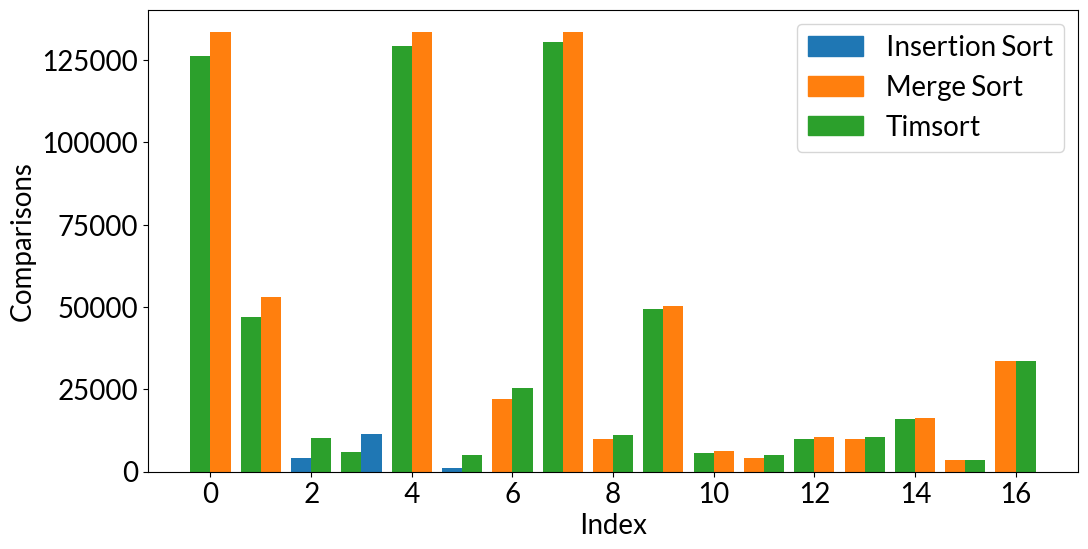

In [11]:
start_time = time.time()

y_pred_all = best_model.predict(X_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

print("Time to predict the test set: " + str(elapsed_time))

y_pred_all_classes = np.argmax(y_pred_all, axis=1)
predicted_algorithms_all = label_encoder.inverse_transform(y_pred_all_classes)

df_results["y_pred"] = predicted_algorithms_all

test_set_df = df_results.iloc[test_indices]
test_set_df.reset_index(drop=True, inplace=True)

print("size of test set: " + str(len(test_set_df)))

missclassified_df = test_set_df[test_set_df["Algorithm"] != test_set_df["y_pred"]].copy()

missclassified_df.reset_index(drop=True, inplace=True)

print("number of missclassifications: " + str(len(missclassified_df)))

missclassified_df["f"] = missclassified_df.apply(lambda row: row[row["y_pred"]], axis=1)
missclassified_df["t"] = missclassified_df.apply(lambda row: row[row["Algorithm"]], axis=1)

missclassified_df["abs_diff"] = missclassified_df["f"] - missclassified_df["t"]

# Sort by absolute difference in descending order
missclassified_df = missclassified_df.sort_values(by="abs_diff", ascending=False).reset_index(drop=True)
print(missclassified_df)

unique_algorithms = list(set(missclassified_df["Algorithm"].unique()) | set(missclassified_df["y_pred"].unique()))
palette = sns.color_palette("tab10", len(unique_algorithms))
color_map = dict(zip(unique_algorithms, palette))

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(missclassified_df.index - 0.2, missclassified_df["t"], width=0.4, 
       color=[color_map[alg] for alg in missclassified_df["Algorithm"]])

ax.bar(missclassified_df.index + 0.2, missclassified_df["f"], width=0.4, 
       color=[color_map[alg] for alg in missclassified_df["y_pred"]])

ax.set_xticks(missclassified_df.index[::2])

legend_labels = {
    "merge_sort": "Merge Sort",
    "insertion_sort": "Insertion Sort",
    "timsort": "Timsort"
}

legend_patches = [
    mpatches.Patch(color=color_map[alg], label=legend_labels.get(alg, alg))
    for alg in unique_algorithms
]

ax.legend(handles=legend_patches, loc="upper right")

ax.set_xlabel("Index")
ax.set_ylabel("Comparisons")
# ax.set_title("True Algorithms (left) False predicted Algorithms (right)")

font_manager.fontManager.addfont("C:/Users/david/Downloads/Lato/Lato-Regular.ttf")  # put Lato .ttf in same folder

plt.rc('font', family='Lato', size=24)  # only applies on a second run

plt.savefig("MissclassifiedAlgos(4.7).svg", format='svg')
plt.show()

---

## Best Model Predictions Compared to Timsort

This section highlights the **largest improvements** achieved by the model relative to Timsort.
The analysis computes, for each test instance, the absolute difference in the number of comparisons between **Timsort** and the algorithm predicted by the model. The 15 cases with the greatest improvements are selected for visualization.

The figure presents a side-by-side comparison for each selected sequence:  
- The **left bar** (blue) shows the number of comparisons required by Timsort.  
- The **right bar** (colored by algorithm type) shows the number of comparisons required by the model’s predicted algorithm.

---

C:\Users\david\AppData\Local\Temp\ipykernel_15396\3522122447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_df["difference"] = np.abs(test_set_df["timsort"] - test_set_df.apply(lambda row: row[row["y_pred"]], axis=1))


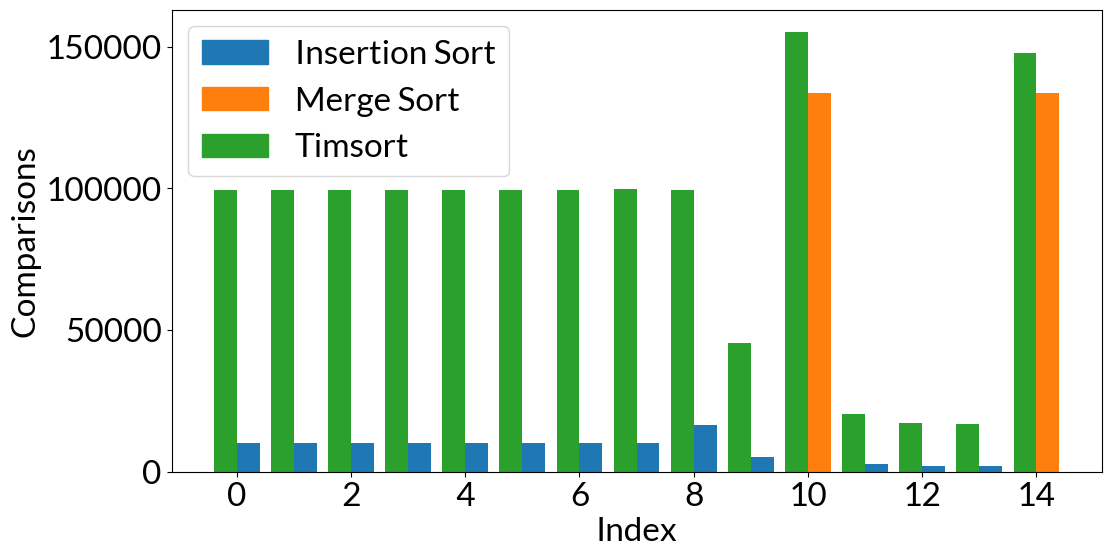

In [12]:
# Calculate absolute difference between "y_pred" column and "timsort"
test_set_df["difference"] = np.abs(test_set_df["timsort"] - test_set_df.apply(lambda row: row[row["y_pred"]], axis=1))

# Select the 20 rows with the largest difference
test_df_15 = test_set_df.nlargest(15, "difference").copy()
test_df_15.reset_index(drop=True, inplace=True)

test_df_15.drop(columns=["difference"], inplace=True)

test_df_15["f"] = test_df_15.apply(lambda row: row[row["y_pred"]], axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(test_df_15.index - 0.2, test_df_15["timsort"], width=0.4, color=[color_map["timsort"]])

ax.bar(test_df_15.index + 0.2, test_df_15["f"], width=0.4, 
       color=[color_map[alg] for alg in test_df_15["y_pred"]])

legend_patches = [mpatches.Patch(color=color_map[alg], label=legend_labels.get(alg, alg))
    for alg in unique_algorithms]

ax.legend(handles=legend_patches, loc="upper left")

ax.set_xlabel("Index")
ax.set_ylabel("Comparisons")
# ax.set_title("Timsort (left) vs Predicted Algorithms (right) - Biggest Improvements")

plt.rc('font', family='Lato', size=24)  # only applies on a second run

plt.savefig("BestPredictions(4.7).svg", format='svg')
plt.show()

---

## Algorithm Prediction Summary

This section compares the **actual vs. predicted counts** for each sorting algorithm in the test set and reports the number of **true positives** per class.

---


In [13]:
actual_counts = test_set_df["Algorithm"].value_counts()
predicted_counts = test_set_df["y_pred"].value_counts()

correct_merge_count = ((test_set_df["y_pred"] == "merge_sort") & (test_set_df["Algorithm"] == "merge_sort")).sum()
correct_insertion_count = ((test_set_df["y_pred"] == "insertion_sort") & (test_set_df["Algorithm"] == "insertion_sort")).sum()
correct_timsort_count = ((test_set_df["y_pred"] == "timsort") & (test_set_df["Algorithm"] == "timsort")).sum()

summary_table = pd.DataFrame({
    "Actual Count": actual_counts,
    "Predicted Count": predicted_counts
})

print(summary_table)
print("true positive insertion_sort :" + str(correct_insertion_count))
print("true positive merge_sort :" + str(correct_merge_count))
print("true positive timsort :" + str(correct_timsort_count))

                Actual Count  Predicted Count
merge_sort               180              182
timsort                   52               51
insertion_sort            22               21
true positive insertion_sort :20
true positive merge_sort :174
true positive timsort :43


---

## Overall Model Performance Relative to Timsort

This figure places the model’s performance into context by comparing it with baseline and reference values:  

- **Timsort** serves as the baseline and is normalized to 100%.  
- **Best possible** represents the theoretical lower bound always choosing the most comparison efficient sorting algorithm.  
- **Model** reflects the performance of the final neural network model.
- The **overhead of presortedness calculation** is displayed separately as an orange bar stacked on top of the model’s prediction cost.  

---

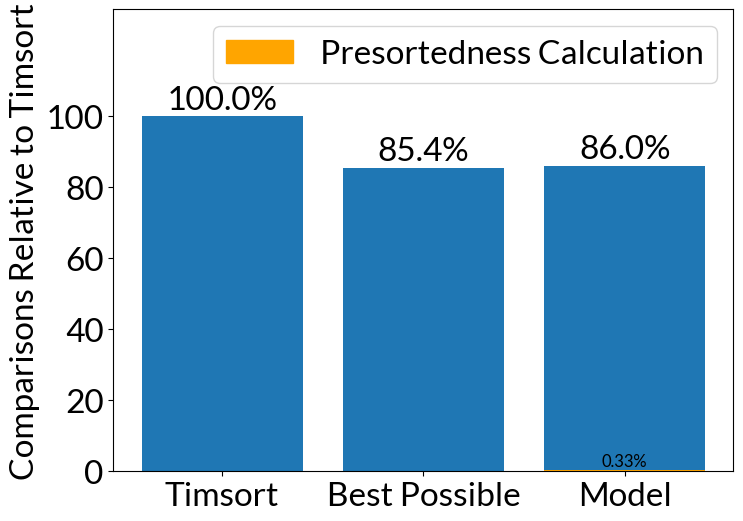

In [14]:
timsort_value = 45751.6
prediction_model_value = 39365
presortedness_value = 152.2
minimum_possible_value = 39061.5

# Compute relative percentages
timsort_percentage = 100 
prediction_percentage = (prediction_model_value / timsort_value) * 100
presortedness_percentage = (presortedness_value / timsort_value) * 100
minimum_percentage = (minimum_possible_value / timsort_value) * 100

bar_labels = ["Timsort", "Best Possible", "Model"]
main_bar_values = [timsort_percentage, minimum_percentage, prediction_percentage]
presorted_bar_value = [0, 0, presortedness_percentage]

colors_bottom = ["none", "none", "orange"]

fig, ax = plt.subplots(figsize=(8, 6))

bars_main = ax.bar(bar_labels, main_bar_values)

bars_bottom = ax.bar(bar_labels, presorted_bar_value, color=colors_bottom)

ax.set_ylabel("Comparisons Relative to Timsort")
# ax.set_title("Sorting Algorithm Comparisons (Relative to Timsort = 100%)")

for bar, value in zip(bars_main, main_bar_values):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 2, f"{value:.1f}%", ha="center", fontsize=24)

ax.text(bars_bottom[2].get_x() + bars_bottom[2].get_width() / 2, presortedness_percentage + 1,  
        f"{presortedness_percentage:.2f}%", ha="center", fontsize=12, color="black")

legend_patch = mpatches.Patch(color="orange", label="Presortedness Calculation")
ax.legend(handles=[legend_patch], loc="upper right")
ax.set_ylim(0, 130)
ax.set_yticks(np.arange(0, 101, 20))

plt.rc('font', family='Lato', size=20)  # only applies on a second run
plt.savefig("OverallPerformance.svg", format='svg')
plt.show()